# Analysis Notebook
1. Setup
2. Set up directory
3. Load logging file
4. 

# 1 - Setup

In [1]:
import matplotlib.pyplot as plt
import itertools
import copy
import warnings
import json
import numpy as np
import os
import math
import torch
%load_ext autoreload
%autoreload 2

# 2- Set up directory

In [11]:
# Load logging file

# we want to leave the ss18_showmaster git (../../../)
path = "../../../ParlAI/data/models/convai2/"
folder = "kvmemnn"
session_directory = os.path.join(path, file)

#print(session_directory)
#root, dirs, files = (os.walk(session_directory))
for root, dirs, files in (os.walk(session_directory)):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))
    print(root)
    print(dirs)
    print(files)

../../../ParlAI/data/models/convai2/kvmemnn/kvmemnn.txt
../../../ParlAI/data/models/convai2/kvmemnn/model.candspair2
../../../ParlAI/data/models/convai2/kvmemnn/model.dict
../../../ParlAI/data/models/convai2/kvmemnn/.built
../../../ParlAI/data/models/convai2/kvmemnn/model.opt
../../../ParlAI/data/models/convai2/kvmemnn/model
../../../ParlAI/data/models/convai2/kvmemnn/model.candspair
../../../ParlAI/data/models/convai2/kvmemnn/model.best_valid
../../../ParlAI/data/models/convai2/kvmemnn
[]
['kvmemnn.txt', 'model.candspair2', 'model.dict', '.built', 'model.opt', 'model', 'model.candspair', 'model.best_valid']


# 3- Load Data

In [12]:
#results = {}
#loggings = 

model = "kvmemnn"

with open ((path + folder + "/" + model + ".txt"), 'rt') as in_file:  # Open file lorem.txt for reading of text data.
    log = in_file.read()# Read the entire file into a variable named contents.
    print(log) # Print contents.

[ Main ParlAI Arguments: ] 
[  task: convai2:self_revised ]
[  download_path: /home/team_roboy/ParlAI/downloads ]
[  datatype: train ]
[  image_mode: raw ]
[  numthreads: 40 ]
[  hide_labels: False ]
[  datapath: /home/team_roboy/ParlAI/data ]
[ Batching Arguments: ] 
[  batchsize: 1 ]
[  include_labels: True ]
[ ParlAI Model Arguments: ] 
[  model: projects.personachat.kvmemnn.kvmemnn:KvmemnnAgent ]
[  model_file: /tmp/persona_self_rephrase ]
[  dict_class: parlai.core.dict:DictionaryAgent ]
[ Training Loop Arguments: ] 
[  evaltask: convai2:self ]
[  display_examples: False ]
[  num_epochs: -1 ]
[  max_train_time: 28800 ]
[  log_every_n_secs: 10 ]
[  validation_every_n_secs: 900 ]
[  save_every_n_secs: -1 ]
[  save_after_valid: False ]
[  validation_max_exs: -1 ]
[  validation_patience: -1 ]
[  validation_metric: accuracy ]
[  validation_metric_mode: max ]
[  validation_cutoff: 1.0 ]
[  dict_build_first: True ]
[  load_from_checkpoint: False ]
[ Dictionary Loop Arguments: ] 
[  dict_

# 4 - Create Dictionary

In [16]:
# reverse engineer logged shell output from string to dictionary
log_dict = dict()
time_between_validations = 30

# needed to extract relevant entreis form string
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


with open ((path + file + "/" + model + ".txt"), 'rt') as fp: 
    line = fp.readline()
    cnt = 1
    dict_cnt = 1
    val_time = time_between_validations
    while line:
        teststring = line.strip()
        
        # filter for relevant lines
        if (teststring[0:7] == '[ time:') == True:
            
            # extract relevant entries form string
            time = float(find_between( teststring, "time:", "s " ))   
            parleys = float(find_between( teststring, "parleys:", " " ))
            time_left = float(find_between( teststring, "time_left:", "s " ))
            
            total = float(find_between( teststring, "'total': ", ", " ))
            mean_rank = float(find_between( teststring, "'mean_rank':", ", " ))
            #accuracy = float(find_between( teststring, "'accuracy': ", "}" ))
            #f1 = float(find_between( teststring, "'f1': ", ", " ))
            loss = float(find_between( teststring, "'loss': ", "}" ))
            #ppl = float(find_between( teststring, "'ppl': ", ", " ))
            
            #total = float(find_between( teststring, "'total': ", ", 'accuracy':" ))
            #accuracy = float(find_between( teststring, "'accuracy': ", ", 'f1':" ))
            #f1 = float(find_between( teststring, "'f1': ", ", 'loss'" ))
            #loss = float(find_between( teststring, "'loss': ", ", 'ppl'" ))
            #ppl = float(find_between( teststring, "'ppl': ", "}" ))                  
            
            #save to dictionary
            log_dict[dict_cnt] = {'time': time, 'parleys': parleys, 'time_left': time_left,'total': total, 'mean_rank': mean_rank, 'loss': loss}
                                  #'train_accuracy': accuracy, 'val_accuracy': None, 'f1': f1, 'loss': loss, 'ppl': ppl}
            dict_cnt += 1
        
        # log validations every x seconds
        #elif (teststring[0:7] == 'valid:{') == True:
        #    total = float(find_between( teststring, "'total': ", ", " ))
        #    accuracy = float(find_between( teststring, "'accuracy': ", "}" ))
        #    f1 = float(find_between( teststring, "'f1': ", ", " ))
        #    loss = float(find_between( teststring, "'loss': ", ", " ))
            #ppl = float(find_between( teststring, "'ppl': ", ", " ))
        #    log_dict[dict_cnt] = {'time': val_time, 'total': total, 'train_accuracy': None,'val_accuracy': accuracy, 'f1': f1, 'loss': loss, 'ppl': ppl}
        #    val_time += time_between_validations
        #    dict_cnt += 1
        
        line = fp.readline()
        cnt += 1
print(log_dict)

{1: {'time': 10.0, 'parleys': 6561.0, 'time_left': 28787.0, 'total': 6523.0, 'mean_rank': 3.679, 'loss': 1.065}, 2: {'time': 20.0, 'parleys': 12651.0, 'time_left': 28777.0, 'total': 6078.0, 'mean_rank': 3.275, 'loss': 0.9766}, 3: {'time': 30.0, 'parleys': 18678.0, 'time_left': 28767.0, 'total': 6000.0, 'mean_rank': 3.174, 'loss': 0.9664}, 4: {'time': 40.0, 'parleys': 24779.0, 'time_left': 28757.0, 'total': 6071.0, 'mean_rank': 3.122, 'loss': 0.9592}, 5: {'time': 50.0, 'parleys': 30805.0, 'time_left': 28747.0, 'total': 5996.0, 'mean_rank': 2.976, 'loss': 0.9524}, 6: {'time': 60.0, 'parleys': 36834.0, 'time_left': 28737.0, 'total': 6013.0, 'mean_rank': 2.985, 'loss': 0.9496}, 7: {'time': 70.0, 'parleys': 42877.0, 'time_left': 28727.0, 'total': 6016.0, 'mean_rank': 2.894, 'loss': 0.9468}, 8: {'time': 80.0, 'parleys': 48944.0, 'time_left': 28717.0, 'total': 6047.0, 'mean_rank': 2.897, 'loss': 0.9452}, 9: {'time': 90.0, 'parleys': 54990.0, 'time_left': 28707.0, 'total': 6037.0, 'mean_rank':

# 5 - Plots

In [17]:
### plot parameters
#fontsizes
fs_title = 24
fs_ax_labels = 20
fs_tick_labels=18
fs_legend = 20

is_final_plot = True

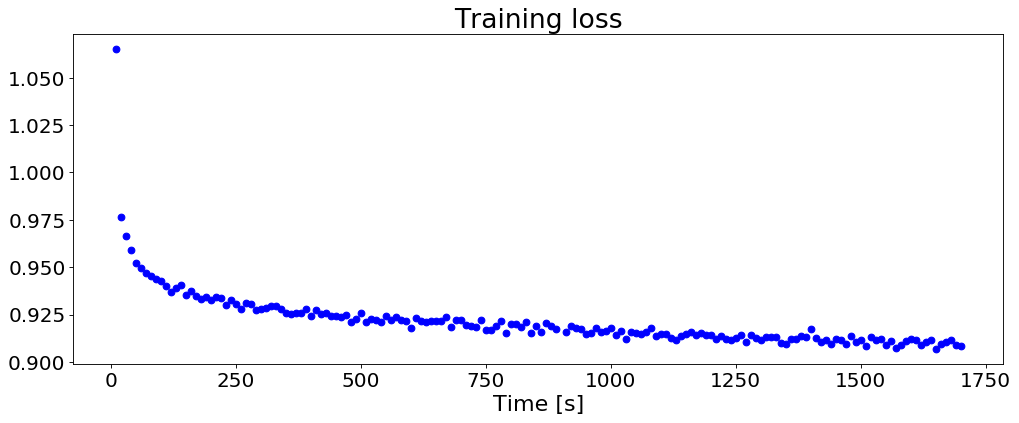

In [18]:
# Plot loss

fig_trloss=plt.figure(dpi= 80, facecolor='w', edgecolor='k')

plot = plt.subplot(2, 1, 1)
plt.title('Training loss',fontsize= fs_title)

for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    loss = log_dict[i]['loss']
    plt.plot(time, loss, marker = 'o', color = 'blue')
plt.xlabel('Time [s]', fontsize= fs_ax_labels)

#plt.legend(loc='best', fontsize = fs_legend)
plt.gcf().set_size_inches(15, 12)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

In [ ]:
# Plot training accuracy

fig_trloss=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
#plot = fig_tr_acc.add_subplot(111)

#plot = plt.subplot(2, 1, 1)
plt.title('Training Accuracy', fontsize=fs_title)


for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    acc = log_dict[i]['train_accuracy']
    if acc != None:
        plt.plot(time, acc, marker = 'o', color = 'blue')

        
plt.xlabel('Time [s]', fontsize = fs_ax_labels)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

In [ ]:
# Plot valdiation accuracy

fig_val_acc=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_val_acc.add_subplot(111)

plt.title('Validation Accuracy', fontsize=fs_title)


for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    acc = log_dict[i]['val_accuracy']
    if acc != None:
        plt.plot(time, acc, marker = 'o', color = 'blue')

plt.xlabel('Epoch', fontsize = fs_ax_labels)
plt.legend(loc='best', fontsize= fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

In [ ]:
### Plot overfitting curves (difference between train_acc and small_val_acc)

fig_overfitting=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_overfitting.add_subplot(111)

plt.title('Overfitting', fontsize=fs_title)

for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    overfit = abs(log_dict[i]['val_accuracy']-log_dict[i]['train_accuracy'])
    
    at_end = overfitting[-1]
    print("\tAverage:%.3f\tOverfitting at end:%.3f" % (average, at_end))
    plt.plot(time, acc, marker = 'o')

    
plt.xlabel('Time', fontsize=fs_ax_labels)
plt.ylabel('acc (train) - acc (val)', fontsize=fs_ax_labels)
plt.legend(loc='best', fontsize=fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)

plt.show()

In [ ]:
### Save graphics
path = '../Poster/GraphicsClipboard/'
#fig_trloss.savefig(path+'tr_loss.pdf',bbox_inches='tight', format='pdf')
# fig_val_acc.savefig(path+'val_acc.pdf',bbox_inches='tight', format='pdf')
# fig_tr_acc.savefig(path+'tr_acc.pdf',bbox_inches='tight', format='pdf')

fig_asl_model.savefig(path+'acc_asl.pdf',bbox_inches='tight', format='pdf')
#fig_combi_model.savefig(path+'acc_combi.pdf',bbox_inches='tight', format='pdf')

#fig_overfitting.savefig(path+'overfitting.pdf',bbox_inches='tight', format='pdf')
#fig_3acc.savefig(path+'3_accuracies.pdf',bbox_inches='tight', format='pdf')
#fig_val_matrix.savefig(path+'val_conf_matrix.pdf',bbox_inches='tight', format='pdf')
#fig_test_matrix.savefig(path+'test_conf_matrix.pdf',bbox_inches='tight', format='pdf')

# X - other

In [ ]:
# extract from certain line
print(a[182])
teststring = a[182]
#time = 
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""
    
time = find_between( teststring, "time:", "s parleys:" )
parleys = find_between( teststring, "parleys:", " ] {" )
total = find_between( teststring, "'total': ", ", 'accuracy':" )
accuracy = find_between( teststring, "'accuracy': ", ", 'f1':" )
f1 = find_between( teststring, "'f1': ", ", 'loss'" )
loss = find_between( teststring, "'loss': ", ", 'ppl'" )
ppl = find_between( teststring, "'ppl': ", "}" )





print(time)
print(parleys)
print(total)
print(accuracy)
print(f1)
print(loss)
print(ppl)

#print(find_between( s, "time:", "s" ))
#print(find_between_r( s, "time:", "s" ))